<a href="https://colab.research.google.com/github/callee2006/MachineLearning/blob/master/sequence_prediction%20(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [0]:
#MODEL_NAME = 'RNN'
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

# Generate data

This is a toy example to predict a sequence with RNN.
In this example, Y is a sequence of 2D vectors (sin(x), cos(x)) for x in [-3.14, +3.14]

In practical applications, replace Y with the sequence to predict

In [0]:
# range of the data
X = np.linspace(-3.14 * 2, 3.14 * 2, 100)

In [3]:
#Y = np.array([(np.sin(x), np.cos(x)) for x in X])
Y = np.array([(np.sin(x) + np.random.normal(0, 0.1), np.cos(x) + np.random.normal(0, 0.1)) for x in X])
Y[:10]

array([[0.05190287, 1.0847361 ],
       [0.1656199 , 0.9680282 ],
       [0.20852577, 0.99013124],
       [0.40080829, 0.93932601],
       [0.63003734, 0.7932626 ],
       [0.73727632, 0.73207735],
       [0.6040032 , 0.51987857],
       [0.70968566, 0.55598757],
       [0.7625294 , 0.50407891],
       [0.80947848, 0.24755719]])

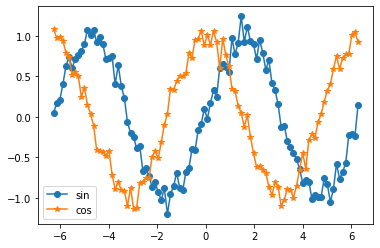

In [4]:
plt.plot(X, Y[:,0], label="sin", marker="o")
plt.plot(X, Y[:,1], label="cos", marker='*')
plt.legend()

# Convert numpy array to torch.Tensor

In [5]:
# convert Y into input tensors
#input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
input_tensor = torch.tensor(Y, dtype=torch.float32)
input_tensor.shape

torch.Size([100, 2])

In [6]:
# check input_tensor
input_tensor[:10]

tensor([[0.0519, 1.0847],
        [0.1656, 0.9680],
        [0.2085, 0.9901],
        [0.4008, 0.9393],
        [0.6300, 0.7933],
        [0.7373, 0.7321],
        [0.6040, 0.5199],
        [0.7097, 0.5560],
        [0.7625, 0.5041],
        [0.8095, 0.2476]])

In [7]:
# make target_tensor by rotating input_tensor
# target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
target_tensor[:10]

tensor([[0.1656, 0.9680],
        [0.2085, 0.9901],
        [0.4008, 0.9393],
        [0.6300, 0.7933],
        [0.7373, 0.7321],
        [0.6040, 0.5199],
        [0.7097, 0.5560],
        [0.7625, 0.5041],
        [0.8095, 0.2476],
        [0.8997, 0.3615]])

In [8]:
# check the input and target tensors
print(torch.cat((input_tensor, target_tensor), 1)[:10])

tensor([[0.0519, 1.0847, 0.1656, 0.9680],
        [0.1656, 0.9680, 0.2085, 0.9901],
        [0.2085, 0.9901, 0.4008, 0.9393],
        [0.4008, 0.9393, 0.6300, 0.7933],
        [0.6300, 0.7933, 0.7373, 0.7321],
        [0.7373, 0.7321, 0.6040, 0.5199],
        [0.6040, 0.5199, 0.7097, 0.5560],
        [0.7097, 0.5560, 0.7625, 0.5041],
        [0.7625, 0.5041, 0.8095, 0.2476],
        [0.8095, 0.2476, 0.8997, 0.3615]])


# Create RNN Class

In [0]:
import torch
import torch.nn as nn


# RNN to predict the sequence

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
#        print("shape = {}, {}".format(input.shape, hidden.shape))
#        print("input = {}".format(input))
#        print("hidden = {}".format(hidden))
      
        input_combined = torch.cat((input, hidden), -1)
        
#        print("combined = {}".format(input_combined))
        
        hidden = self.i2h(input_combined)
        output = self.h2o(hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
#rnn = RNN(2, 32, 2).to(DEVICE)
rnn = RNN(2, 32, 2)

# Train RNN

In [0]:
# select loss function
criterion = nn.MSELoss()

# learning rate
learning_rate = 0.0005

# set optimilzer
optimizer = torch.optim.Adam(rnn.parameters(), lr = learning_rate)

In [0]:
# define train function that trains for one step
def train(input_tensor, target_tensor):
#    hidden = rnn.initHidden().to(DEVICE)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_tensor.size(0)):
#        print("Input = {}, hidden = {}".format(input_tensor[i], hidden))
        output, hidden = rnn(input_tensor[i:i+1], hidden)
#        print("output = {}, target = {}".format(output, target_tensor[i:i+1]))
        l = criterion(output, target_tensor[i:i+1])
        loss += l

    loss.backward()

    optimizer.step()    
#    for p in rnn.parameters():
#        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_tensor.size(0)

### Note that pytorch modules inputs a batch rather than a vector!

In [13]:
# input_tensor[0].shape = torch.Size([2])
input_tensor[0]

tensor([0.0519, 1.0847])

In [14]:
# input_tensor[0:1].shape = torch.Size([1, 2])
input_tensor[0:1]

tensor([[0.0519, 1.0847]])

In [0]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def get_data(X):
#    X = np.linspace(-3.14 * 2, 3.14 * 2, 100)
    Y = np.array([(np.sin(x) + np.random.normal(0, 0.1), np.cos(x) + np.random.normal(0, 0.1)) for x in X])
#    input_tensor = torch.tensor(Y, dtype=torch.float32).to(DEVICE)
    input_tensor = torch.tensor(Y, dtype=torch.float32)
  
#    target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0).to(DEVICE)
    target_tensor = torch.cat((input_tensor[1:], input_tensor[0:1]), 0)
    
    return input_tensor, target_tensor

In [0]:
# reset loss history
all_losses = []

In [18]:
n_iters = 5000
print_every = 200
plot_every = 200
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    input_tensor, target_tensor = get_data(X)
    output, loss = train(input_tensor, target_tensor)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 3s (200 4%) 0.0159
0m 6s (400 8%) 0.0116
0m 10s (600 12%) 0.0117
0m 13s (800 16%) 0.0109
0m 17s (1000 20%) 0.0132
0m 20s (1200 24%) 0.0124
0m 23s (1400 28%) 0.0128
0m 27s (1600 32%) 0.0106
0m 31s (1800 36%) 0.0116
0m 34s (2000 40%) 0.0099
0m 38s (2200 44%) 0.0108
0m 41s (2400 48%) 0.0090
0m 45s (2600 52%) 0.0110
0m 49s (2800 56%) 0.0110
0m 52s (3000 60%) 0.0102
0m 56s (3200 64%) 0.0102
0m 59s (3400 68%) 0.0093
1m 3s (3600 72%) 0.0111
1m 6s (3800 76%) 0.0091
1m 10s (4000 80%) 0.0106
1m 13s (4200 84%) 0.0107
1m 16s (4400 88%) 0.0114
1m 20s (4600 92%) 0.0096
1m 24s (4800 96%) 0.0125
1m 27s (5000 100%) 0.0100


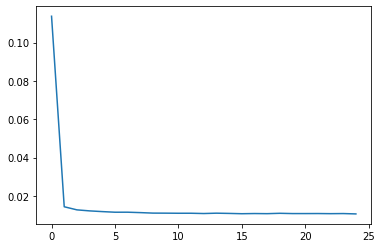

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [20]:
predict_tensor = torch.tensor([[np.sin(X[0]), np.cos(X[0])]])
predict_tensor

tensor([[0.0032, 1.0000]])

In [0]:
hidden = rnn.initHidden();

for i in range(1,len(X)):
#  print("input = {}".format(predict[-1:]))
#  print("hidden = {}".format(hidden))
  output, hidden = rnn(predict_tensor[-1:], hidden)
  predict_tensor = torch.cat((predict_tensor, output), 0)
#  print("predict = {}".format(predict))

In [22]:
predict_tensor[:10]

tensor([[0.0032, 1.0000],
        [0.1327, 0.9791],
        [0.2506, 0.9745],
        [0.3827, 0.9271],
        [0.4793, 0.8797],
        [0.5919, 0.8111],
        [0.6939, 0.7328],
        [0.7796, 0.6398],
        [0.8546, 0.5369],
        [0.9146, 0.4260]], grad_fn=<SliceBackward>)

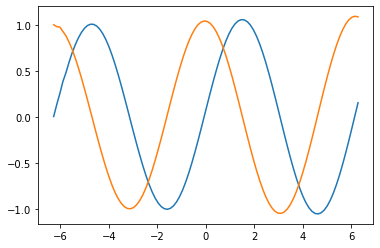

In [23]:
predict = predict_tensor.detach().numpy()
plt.plot (X, predict[:,0])
plt.plot (X, predict[:,1])